In [2]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [13]:
from IPython.display import Image

In [21]:
img = Image('train/ISIC_2105563.jpg')

In [27]:
img_array = np.array(img) / 255
img_array

TypeError: unsupported operand type(s) for /: 'Image' and 'int'

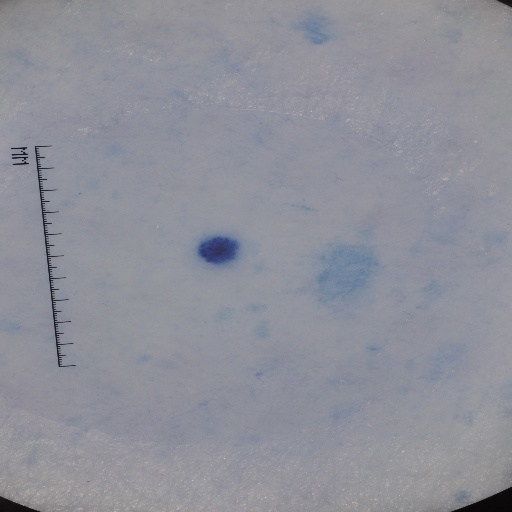

In [14]:
Image('train/ISIC_2105563.jpg')

In [25]:
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, auc, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models
import torch
from torch import nn, optim
from torchvision.io import read_image
from IPython.display import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters grid

epochs_options = [5,8]
learning_rates = [0.001,0.002]
freeze_layers_options = [5,3]
optimizers = [(optim.Adam, {'lr': lr}) for lr in learning_rates]
batch_sizes = [16,32]
early_stopping_patience = 3


# Define transformations for images already in tensor format
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize only
])

class MelanomaDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        print('here')
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0] + '.jpg')
        image = Image(img_path).float()
        #image = np.array(image)
        #image = read_image(img_path).float()  # Image is read as a Tensor

        # Assuming 'target' is the correct column name for the labels
        y_label = torch.tensor(int(self.annotations.iloc[index]['target']))
    

        if self.transform:
            image = self.transform(image)  # Apply resizing and normalization

        return (image, y_label)


# Load the CSV file
data = pd.read_csv("train.csv")
# Separate images with target 0 and 1
target_0 = data[data['target'] == 0]
target_1 = data[data['target'] == 1]

# Randomly select 4416 images with target 0
selected_target_0 = target_0.sample(n=1000, random_state=42)

# Concatenate with 584 images with target 1
selected_data = pd.concat([selected_target_0, target_1])

# Shuffle the concatenated DataFrame
selected_data = selected_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Load data and prepare dataset
train_data = MelanomaDataset(dataframe=selected_data, root_dir="train/", transform=data_transforms)

# All combinations
hyperparams = list(itertools.product(epochs_options, optimizers, freeze_layers_options, batch_sizes))

# Stratified K-Fold and hyperparameter tuning
skf = StratifiedKFold(n_splits=3)
results = {}

for epochs, (optimizer_class, opt_params), freeze_layers, batch_size in hyperparams:
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_data.annotations, train_data.annotations['target'])):
        print(f"Training fold {fold+1} for {epochs} epochs, optimizer {optimizer_class.__name__}, learning rate {opt_params['lr']}, freeze {freeze_layers} layers, batch size {batch_size}")

        # Data loaders
        train_subsampler = Subset(train_data, train_idx)
        val_subsampler = Subset(train_data, val_idx)
        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)
        print("hi")
        # Initialize model
        model = models.resnet18(pretrained=True)
        for i, child in enumerate(model.children()):
            if i < freeze_layers:
                for param in child.parameters():
                    param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, 2)
        model.to(device)
        # Optimizer and loss
        optimizer = optimizer_class(model.fc.parameters(), **opt_params)
        criterion = nn.CrossEntropyLoss()
        # Early stopping variables
        best_val_loss = float('inf')
        patience_counter = 0
        # Training loop with early stopping
        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            # Validation
            val_loss = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    val_loss += criterion(outputs, labels).item()
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Metrics calculation
        y_true, y_pred, y_scores = [], [], []
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
                y_scores.extend(outputs[:, 1].cpu().numpy())
       
        # Confusion matrix and scores
        cm = confusion_matrix(y_true, y_pred)
        # Confusion Matrix
        plt.subplot(1, 3, 3)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')

        plt.show()
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_scores)
        accuracy = np.mean(np.array(y_true) == np.array(y_pred))
        precision_recall_display = precision_recall_curve(y_true, y_scores)
        roc_display = roc_curve(y_true, y_scores)
        print()
        # Plotting ROC and Precision-Recall curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(roc_display[0], roc_display[1], label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        print()
        plt.subplot(1, 2, 2)
        plt.plot(precision_recall_display[0], precision_recall_display[1], label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        plt.legend(loc="lower left")
        plt.show()

        # Save or log results
        results[f'Fold={fold}_Epochs={epochs}_LR={opt_params["lr"]}_Freeze={freeze_layers}_Batch={batch_size}'] = {
            'confusion_matrix': cm,
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'roc_auc': roc_auc,
            'accuracy': accuracy
        }

# Display results for each hyperparameter configuration
for config, metrics in results.items():
    print(f"\nResults for {config}:")
    for key, value in metrics.items():
        print(f"{key}: {value}")


Training fold 1 for 5 epochs, optimizer Adam, learning rate 0.001, freeze 5 layers, batch size 16
hi


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


here


AttributeError: 'Image' object has no attribute 'float'

The error in the end is due to stopping the code from running further as we tried sufficient number of hyperparameter configurations...